In [1]:
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
import itertools
import soundfile as sf
from sklearn import preprocessing
from IPython.display import Audio, display
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


2022-09-09 11:46:34.307629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jelena/sqllib/lib64:/home/jelena/sqllib/lib64/gskit:/home/jelena/sqllib/lib32
2022-09-09 11:46:34.307705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_ravdess_data():
    path = '/home/jelena/Desktop/speech/ravdess/'
    ravdess_directory_list = os.listdir(path)

    emotions = []
    paths = []
    for dir in ravdess_directory_list:
        
        actor = os.listdir(path + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            emotions.append(int(part[2]))
            paths.append(path + dir + '/' + file)

    emotion_df = pd.DataFrame(emotions, columns=['Emotion'])
    path_df = pd.DataFrame(paths, columns=['Path'])
    
    Ravdess_df = pd.concat([path_df,emotion_df], axis=1)

    Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
    
    return Ravdess_df

In [3]:
def load_tess_data():
    
    emotions = []
    paths = []
    path = "/home/jelena/Desktop/speech/Tess/"
    tess_directory_list = os.listdir(path)
    
    for file in tess_directory_list:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions.append('surprise')
        else:
            emotions.append(part)
        paths.append(path + file)

    emotion_df = pd.DataFrame(emotions, columns=['Emotion'])
    path_df = pd.DataFrame(paths, columns=['Path'])
    
    Tess_df = pd.concat([path_df, emotion_df], axis=1)
    
    return Tess_df

In [4]:
def load_savee_data():
    
    emotions = []
    paths = []
    path = "/home/jelena/Desktop/speech/Savee/"
    savee_directory_list = os.listdir(path)
    
    for file in savee_directory_list:
        paths.append(path + file)
        part = file.split('_')[1]
        emo = part[:-6]
        if emo=='a':
            emotions.append('angry')
        elif emo=='h':
            emotions.append('happy')
        elif emo=='sa':
            emotions.append('sad')
        elif emo=='d':
            emotions.append('disgust')
        elif emo=='n':
            emotions.append('neutral')
        elif emo=='f':
            emotions.append('fear')
        else:
            emotions.append('surprise')
            
    emotion_df = pd.DataFrame(emotions, columns=['Emotion'])
    path_df = pd.DataFrame(paths, columns=['Path'])
    
    Savee_df = pd.concat([path_df, emotion_df], axis=1)

    return Savee_df

In [5]:
def load_data():
    ravdess = load_ravdess_data()
    savee = load_savee_data()
    tess = load_tess_data()
    data = pd.concat([savee, tess, ravdess],axis=0)
    return data

In [6]:
data = load_data() 

In [7]:
def vizualisation(data, sr, e):
    plt.title('Vizualization for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


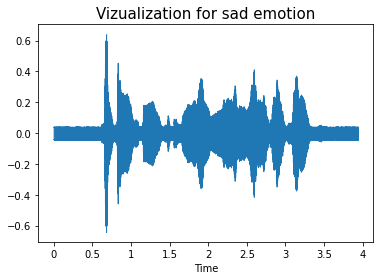

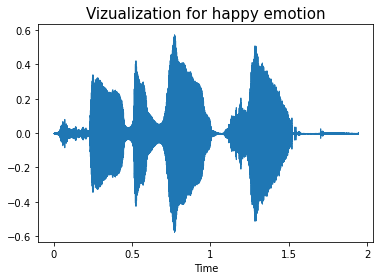

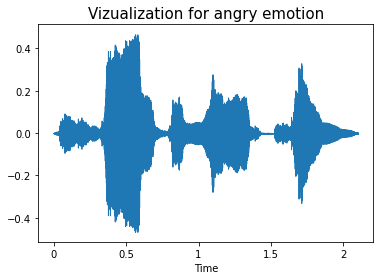

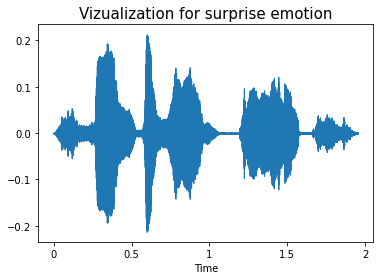

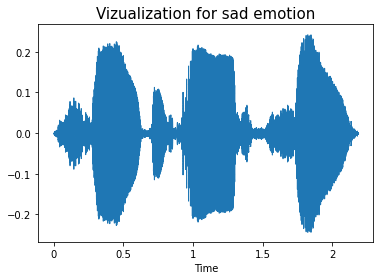

In [8]:
labels = ['neutral', 'neutral','happy','sad','angry','fear','disgust','surprise']
for i in range(5):
    pom_path = np.array(data['Path'])[1+i*500]
    data_, sampling_rate = librosa.load(pom_path)
    vizualisation(data_, sampling_rate, np.array(data['Emotion'])[1+i*500])
    display(Audio(pom_path))

In [9]:
def showMatrix(matrix, model):
    emotions = ['neutral','happy','sad','angry','fear','disgust','surprise']
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.set_title(
        'Confussion matrix for model ' + model,
        loc='center',
        fontsize=18,
        weight='bold'
    )
    
    colors = plt.cm.BuPu(np.linspace(0, 0.5, 7))

    plt.table(matrix,colLabels=emotions, rowLabels=emotions,loc='center',colColours=colors, rowColours=colors)
    
    return

In [10]:
def extract_mfcc(filename):
    with sf.SoundFile(filename) as f:
        data = f.read(dtype="float32")
        result=np.array([])
        sample_rate=f.samplerate
        
        mfccs=np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        
        return result

In [11]:
def get_coef():
    X = []
    Y = []
    for index, row in data.iterrows():
        result = extract_mfcc(row[0])
        X.append(result)
        Y.append(row[1])
    return X,Y

In [12]:
X,Y = get_coef()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.3, random_state=9,shuffle=True)

In [14]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [20]:
model1 = MLPClassifier(alpha=0.01, batch_size=128, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)

In [21]:
model1.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=128, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=1000)

In [22]:
y_pred=model1.predict(x_test)

In [23]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

In [24]:
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 84.18%


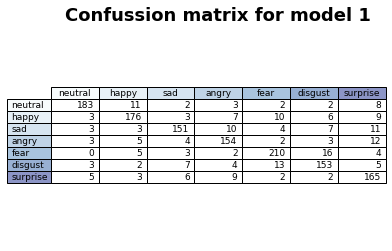

In [25]:
matrix1 = confusion_matrix(y_test, y_pred)
showMatrix(matrix1, "1")

In [27]:
model2 = Sequential()
model2.add(Dense(input_dim = x_train.shape[1],units = 100, activation = 'relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


2022-09-09 11:54:58.484777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jelena/sqllib/lib64:/home/jelena/sqllib/lib64/gskit:/home/jelena/sqllib/lib32
2022-09-09 11:54:58.485490: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 11:54:58.486986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jelena-HP-Laptop-15-bs0xx): /proc/driver/nvidia/version does not exist
2022-09-09 11:54:58.492955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fl

In [28]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)

#train
y_train_pom = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(y_train_pom)

#test
y_true_pom = encoder.transform(y_test)
dummy_y_true = np_utils.to_categorical(y_true_pom)

In [29]:
model2_history = model2.fit(x_train, dummy_y, batch_size = 64, epochs = 40, verbose = 1, validation_split=0.3)

Epoch 1/40
37/37 [==============================] - 1s 16ms/step - loss: 1.5355 - accuracy: 0.4092 - val_loss: 1.1663 - val_accuracy: 0.6028
Epoch 2/40
37/37 [==============================] - 0s 5ms/step - loss: 0.9801 - accuracy: 0.6648 - val_loss: 0.8182 - val_accuracy: 0.7097
Epoch 3/40
37/37 [==============================] - 0s 5ms/step - loss: 0.7519 - accuracy: 0.7336 - val_loss: 0.7068 - val_accuracy: 0.7470
Epoch 4/40
37/37 [==============================] - 0s 5ms/step - loss: 0.6489 - accuracy: 0.7673 - val_loss: 0.6402 - val_accuracy: 0.7681
Epoch 5/40
37/37 [==============================] - 0s 5ms/step - loss: 0.5781 - accuracy: 0.7915 - val_loss: 0.6046 - val_accuracy: 0.7762
Epoch 6/40
37/37 [==============================] - 0s 6ms/step - loss: 0.5217 - accuracy: 0.8153 - val_loss: 0.5816 - val_accuracy: 0.7823
Epoch 7/40
37/37 [==============================] - 0s 9ms/step - loss: 0.4726 - accuracy: 0.8365 - val_loss: 0.5653 - val_accuracy: 0.7903
Epoch 8/40
37/37 [=

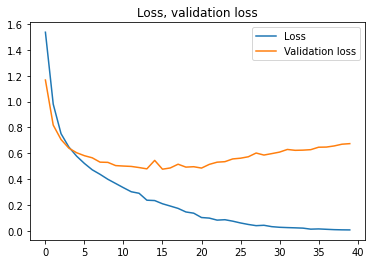

In [30]:
epochs = model2_history.epoch
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']
plt.title("Loss, validation loss")
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(["Loss","Validation loss"])

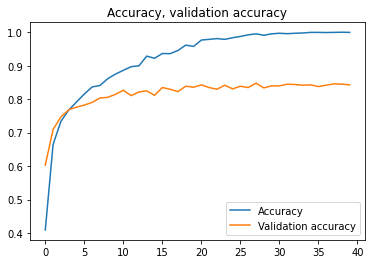

In [31]:
acc = model2_history.history['accuracy']
val_acc = model2_history.history['val_accuracy']
plt.title("Accuracy, validation accuracy")
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(["Accuracy","Validation accuracy"])

In [32]:
model2.evaluate(x_test, dummy_y_true, batch_size=64)

23/23 [==============================] - 0s 3ms/step - loss: 0.8666 - accuracy: 0.8136


[0.8665894865989685, 0.8135592937469482]

In [33]:
y_pred_e = np.argmax(model2.predict(x_test), axis=1)

45/45 [==============================] - 0s 2ms/step


In [34]:
accuracy = accuracy_score(y_true_pom, y_pred_e)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 81.36%


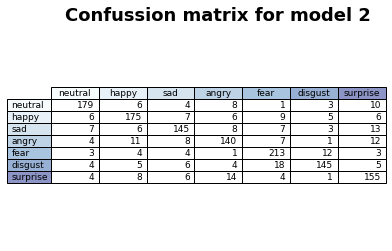

In [35]:
matrix2 = confusion_matrix(y_true_pom, y_pred_e)
showMatrix(matrix2, "2")